### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

### Preprocessing Data
We start preprocessing the geochemical and magnetic susceptibility datasets
for further analysis. 

The following steps include loading the susceptibility and geochemistriy datasets, merge on the sample 
and cleaning the data.

We first get the raw data and resolve `NaN` values. In this first approach we get rid of the columns with `NaN`s.

In [2]:
# This dataset contains geochemical measurements for different samples.
df_xrf_corrected = pd.read_csv('../Data/TG_xrf_corrected.csv')

# This dataset includes magnetic susceptibility measurements for the samples.
df_susc = pd.read_csv('../Data/TG_Bulk_Susceptibility_all.csv')

# We perform a left join to retain all XRF data and add susceptibility values where available.
df_all = pd.merge(df_xrf_corrected, df_susc[['sample','X_fv']], on='sample', how='left')

### Remove samples with missing susceptibility values
df_all = df_all[~df_all['X_fv'].isna()]

### Drop categorical identifiers
# The 'sample' and 'section' columns are metadata and are not needed for numerical analysis.
df_all = df_all.drop(columns = ['sample', 'section'])

### Handling Missing Data
Before performing further analysis, we check for `Nan` values in the dataframe (<LOD; below limit of detection). If any missing values exist, we replace them with 0.0

In [3]:
nan_counts = df_all.isna().sum()
print("Number of nans: ", np.sum(nan_counts))

# Fill NaNs with 0.0 and verify that no missing values remain
df = df_all.fillna(0.0)
assert np.sum(df.isna().sum()) == 0

Number of nans:  3614


### Compute Ratios


In [4]:
add_ratios = True

if add_ratios:
    
    df['Rb/Sr'] = df['Rb'] /  df['Sr']
    df['Ca/Al'] = df['Ca'] /  df['Al2O3']
    df['Fe/S']  = df['Fe'] / df['S']
    df['Si/Al'] = df['SiO2'] / df['Al2O3']
    df['K/Al']  = df['K2O'] / df['Al2O3']
    df['K/Rb']  = df['K2O'] / df['Rb']
    df['Rb/Al'] = df['Rb'] / df['Al2O3']
    df['Si/Al'] = df['SiO2'] / df['Al2O3']
    df['Ti/Al'] = df['Ti'] / df['Al2O3'] # https://cp.copernicus.org/articles/20/415/2024/cp-20-415-2024.pdf

    # Replace nans again but now by infinity
    print("Total number of NaNs after ratios: ", np.sum(df.isna().sum()))
    df = df.replace([np.inf, -np.inf], 999)

df.head(5)

Total number of NaNs after ratios:  0


,MgO,Al2O3,SiO2,S,Cl,K2O,V,Cr,Co,Ni,Cu,Zn,Ga,As,Se,Rb,Sr,Y,Zr,Nb,Mo,Rh,Pd,Cd,Sn,Sb,Ba,La,Ce,Hf,Ta,W,Hg,Tl,Pb,Bi,Th,U,Ti,Fe,Mn,Ca,P,X_fv,Rb/Sr,Ca/Al,Fe/S,Si/Al,K/Al,K/Rb,Rb/Al,Ti/Al
0,0.355997,0.721009,1.792094,0.094367,0.333100,0.107371,0.0,0.001419,0.0,0.001008,0.005268,0.000656,0.0,0.0006,0.00045,0.000302,0.141366,0.000000,0.005311,0.00055,0.0,0.0,0.0,0.0000,0.0067,0.00360,0.00000,0.0,0.0263,0.0,0.0,0.0000,0.0,0.0,0.0020,0.0,0.00000,0.0,0.027419,0.127853,0.029152,38.297890,0.017566,1.283333e-10,0.002138,53.117064,1.354856,2.485535,0.148918,355.221846,0.000419,0.038029
1,0.509463,0.316316,0.770036,0.040300,0.196200,0.025024,0.0,0.000913,0.0,0.001049,0.001374,0.000382,0.0,0.0000,0.00050,0.000041,0.154222,0.000385,0.000000,0.00000,0.0,0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0.0000,0.0,0.0,0.0033,0.0,0.0,0.0022,0.0,0.00120,0.0,0.000000,0.066850,0.023049,37.894305,0.014517,9.380000e-11,0.000264,119.798828,1.658805,2.434386,0.079111,614.356931,0.000129,0.000000
2,0.981638,0.424395,1.480776,0.075350,0.291400,0.032599,0.0,0.001043,0.0,0.001066,0.001616,0.000186,0.0,0.0000,0.00040,0.000112,0.068095,0.000000,0.000000,0.00050,0.0,0.0,0.0,0.0000,0.0046,0.00375,0.00700,0.0,0.0206,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.00145,0.0,0.000000,0.110581,0.039253,39.223767,0.015431,-9.800000e-11,0.001646,92.422822,1.467567,3.489147,0.076812,290.906141,0.000264,0.000000
3,0.372074,0.347958,2.243057,0.116700,0.400067,0.047171,0.0,0.001568,0.0,0.001015,0.002339,0.000395,0.0,0.0000,0.00045,0.000136,0.125279,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0013,0.0053,0.00000,0.00000,0.0,0.0225,0.0,0.0,0.0000,0.0,0.0,0.0016,0.0,0.00000,0.0,0.000000,0.085692,0.034099,38.650576,0.014376,6.038333e-11,0.001084,111.078382,0.734294,6.446351,0.135565,347.265956,0.000390,0.000000
4,0.389912,0.104736,0.669288,0.037900,0.216333,0.035737,0.0,0.001390,0.0,0.001008,0.001340,0.000630,0.0,0.0000,0.00035,0.000017,0.119202,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0000,0.0000,0.00000,0.01215,0.0,0.0256,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.00120,0.0,0.000000,0.092975,0.030988,38.481485,0.012827,5.107333e-11,0.000142,367.414438,2.453168,6.390245,0.341208,2107.555629,0.000162,0.000000


We now separate the feature matrix ($X$) from the target data ($Y$):

In [5]:
target = 'X_fv' 

# Feature matrix
X = df.drop(columns=[target])  
feature_names = X.columns

# Response vector
Y = df[target] 

X.shape, Y.shape

((164, 51), (164,))

We rescale the response vector (multiplying by 10**10). This is not required for many ML methods, including random forrest and XGBoost, but it does not hurt to do it and we have seen this leads to better result performances. See the [issue](https://github.com/scikit-learn/scikit-learn/issues/29922#issuecomment-2460276129) in the Scikit-learn documentation for more information. |

In [6]:
X = X
Y *= 10 ** 10 

## Data Splitting: Training and Testing Sets

Before training our models, we split the dataset into **training** and **testing** sets. This ensures that we can evaluate the model's performance on unseen data.

- **`X_train`**, **`X_test`**: Feature variables for training and testing.
- **`Y_train`**, **`Y_test`**: Target variable for training and testing.
- The split is done using an **80/20 ratio**, where 80% of the data is used for training and 20% for testing.
- We set `random_state=42` to ensure reproducibility of the results.


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model Selection and Hyperparameter Tuning

In this section, we define a set of machine learning regression models and evaluate their performance. The models include:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree
- k-Nearest Neighbors (kNN)
- Random Forest
- Support Vector Regression (SVR)

For **Random Forest** and **SVR**, we apply **hyperparameter tuning** using `GridSearchCV` to find the best model configurations. The dataset is standardized before training these models to ensure optimal performance.

At the end, we compare the models based on **Mean Squared Error (MSE)** and **R² score**.


In [8]:
# Define your models 
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'kNN': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

# Parameter grids for tuning
param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 0.1, 1, 10]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Dictionary to store MSE values for each model
mse_values = {}

for name, model in models.items():
    # Check if the model is Random Forest or SVR
    if name in ['Random Forest', 'SVR']:
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Apply parameter tuning using GridSearchCV
        if name == 'SVR':
            grid_search = GridSearchCV(SVR(kernel='rbf'),
                                       param_grid_svr,
                                       cv=5,
                                       n_jobs=-1)
            grid_search.fit(X_train_scaled, Y_train)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for SVR: {grid_search.best_params_}")
            predictions = best_model.predict(X_test_scaled)
        elif name == 'Random Forest':
            grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                                       param_grid_rf,
                                       cv=5,
                                       n_jobs=-1)
            grid_search.fit(X_train_scaled, Y_train)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for Random Forest: {grid_search.best_params_}")
            predictions = best_model.predict(X_test_scaled)
    else:
        # For other models, fit without scaling or tuning
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
    
    # Compute the error metrics
    mse = mean_squared_error(Y_test, predictions)
    mse_values[name] = mse
    print(f"{name}: MSE = {mse:.4e}, R^2 = {r2_score(Y_test, predictions):.4f}")

Linear Regression: MSE = 3.4472e+04, R^2 = -63.1172
Ridge Regression: MSE = 7.4097e+04, R^2 = -136.8182
Lasso Regression: MSE = 3.0710e+04, R^2 = -56.1193
Decision Tree: MSE = 2.5823e+02, R^2 = 0.5197
kNN: MSE = 2.7496e+02, R^2 = 0.4886


/Users/leandrog/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.629e+04, tolerance: 6.921e+00
  model = cd_fast.enet_coordinate_descent(


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest: MSE = 2.3301e+02, R^2 = 0.5666
Best parameters for SVR: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}
SVR: MSE = 3.1374e+02, R^2 = 0.4164


## Model Performance Comparison

After training and evaluating our models, we compare their **Mean Squared Error (MSE)** values using a bar plot.

- The MSE values for each model are extracted and plotted.
- Since MSE values can vary significantly across models, we use a **logarithmic scale** on the Y-axis for better visualization.
- Model names are displayed on the X-axis, with their corresponding MSE values labeled on top of each bar.

This visualization helps in identifying the most effective models based on their error metrics.


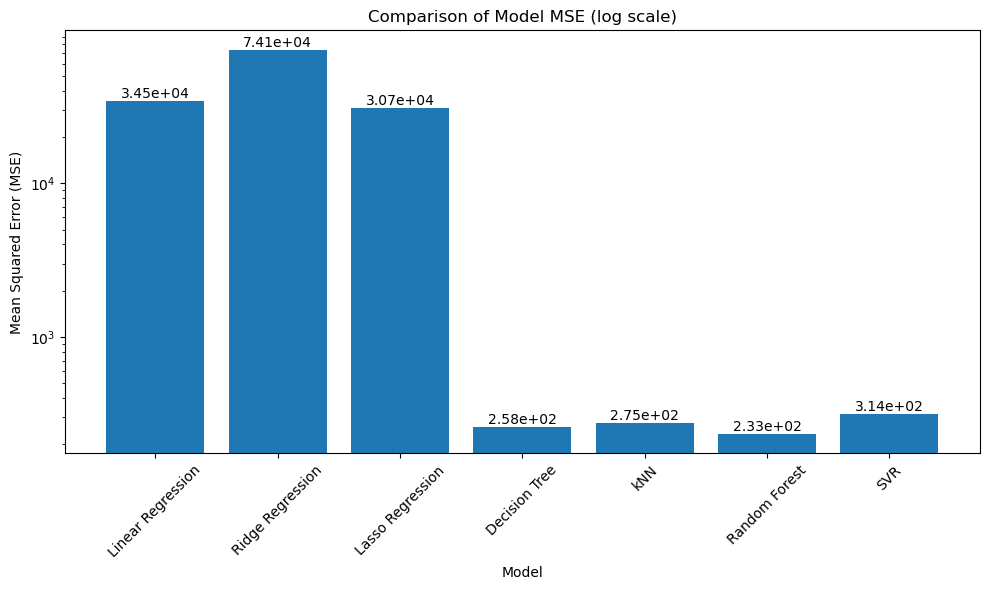

In [9]:
# Create a list of model names and their corresponding MSE values
model_names = list(mse_values.keys())
mse_scores = list(mse_values.values())

# Create the barplot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mse_scores)

# Set logarithmic scale for Y-axis
plt.yscale('log')

# Label the plot
plt.xlabel("Model")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Comparison of Model MSE (log scale)")
plt.xticks(rotation=45)

# Optionally, add the MSE values on top of the bars
for bar, mse in zip(bars, mse_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{mse:.2e}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


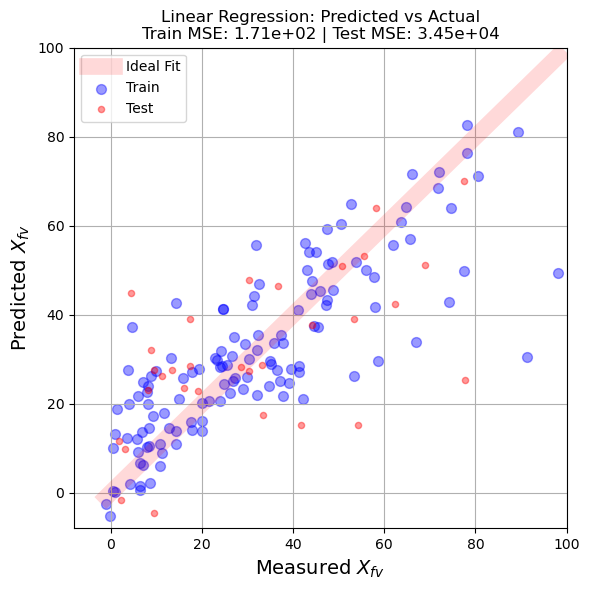

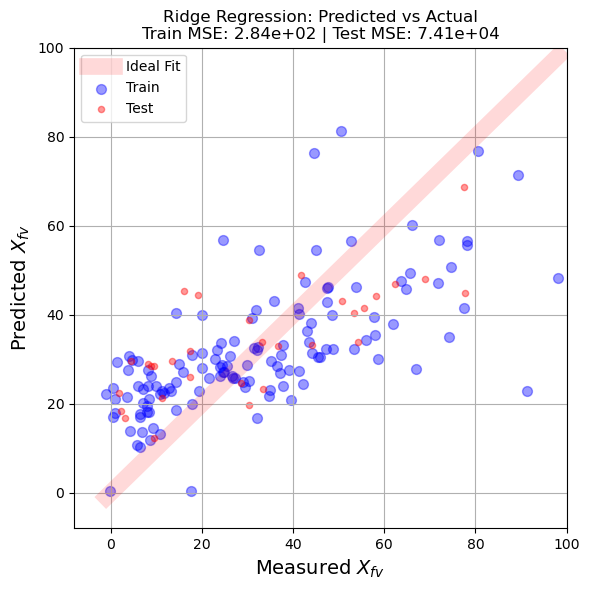

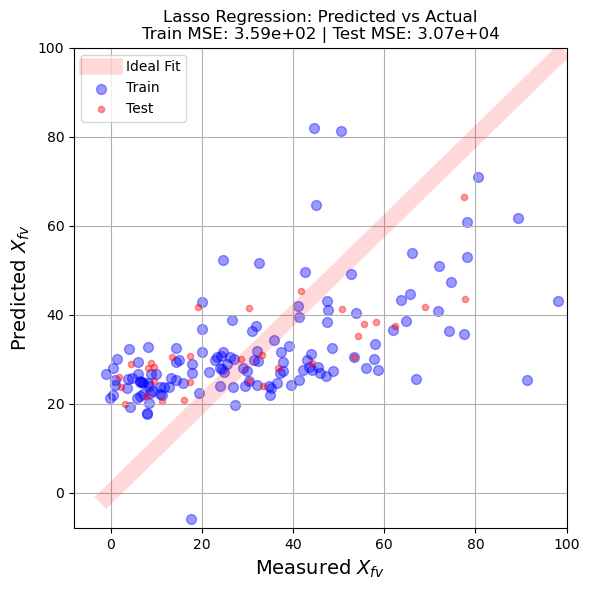

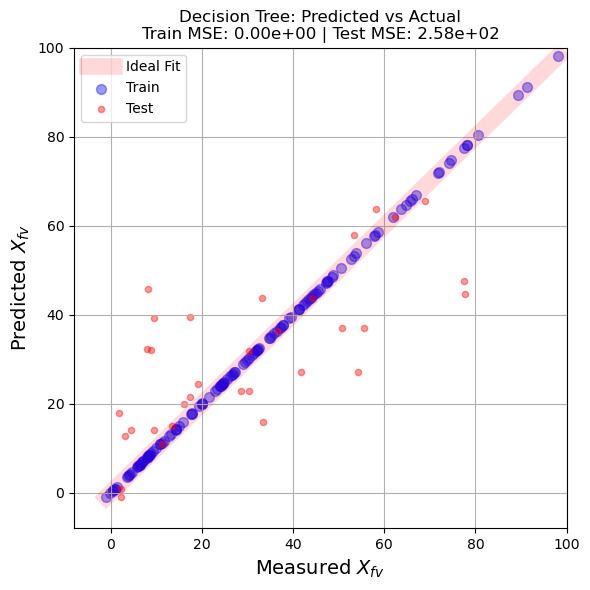

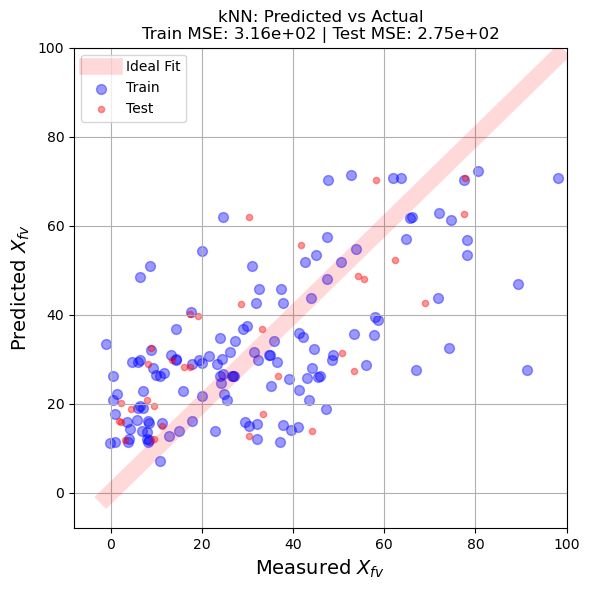

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


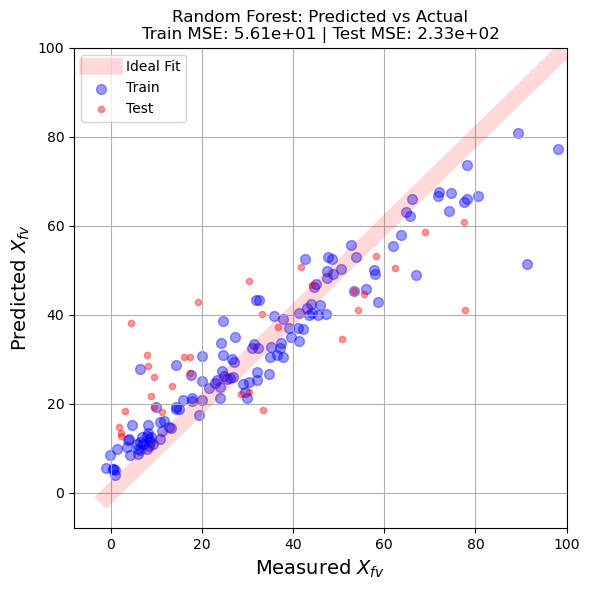

Best parameters for SVR: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}


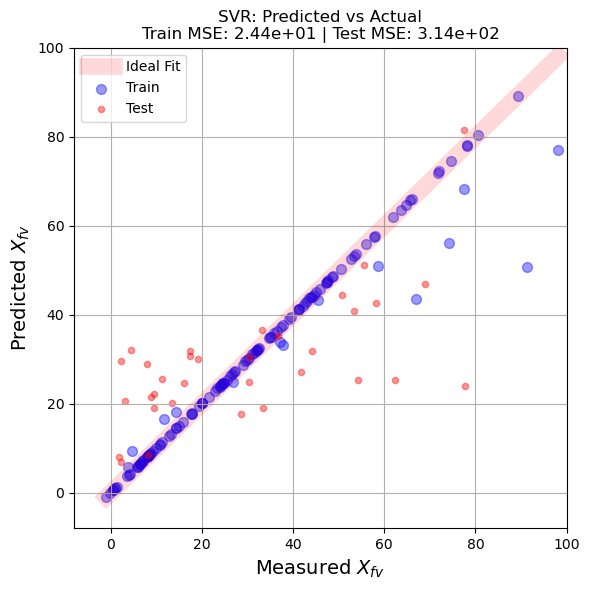

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Define parameter grids for tuning
param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'gamma': ['scale', 0.1, 1, 10]
}
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Iterate over models
for name, model in models.items():
    # For models that require scaling and tuning, run GridSearchCV
    if name in ['Random Forest', 'SVR']:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        if name == 'SVR':
            grid_search = GridSearchCV(SVR(kernel='rbf'),
                                       param_grid_svr,
                                       cv=5,
                                       n_jobs=-1)
            grid_search.fit(X_train_scaled, Y_train)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for SVR: {grid_search.best_params_}")
        elif name == 'Random Forest':
            grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                                       param_grid_rf,
                                       cv=5,
                                       n_jobs=-1)
            grid_search.fit(X_train_scaled, Y_train)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for Random Forest: {grid_search.best_params_}")
        
        # Use the tuned and fitted model for predictions
        y_train_pred = best_model.predict(X_train_scaled)
        y_test_pred = best_model.predict(X_test_scaled)
    
    else:
        # For other models, assume they are already fitted
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
    # Combine all actual values to determine plot limits.
    Y_all = np.concatenate([Y_train, Y_test])
    
    
    # Calculate MSE for train and test predictions
    train_mse = mean_squared_error(Y_train, y_train_pred)
    test_mse  = mean_squared_error(Y_test, y_test_pred)
    
    
    plt.figure(figsize=(6, 6))
    
    # Plot ideal fit line based on min and max of actual values.
    plt.plot([Y_all.min(), Y_all.max()], [Y_all.min(), Y_all.max()], color='red', alpha = 0.15, linewidth = 12, label="Ideal Fit")
    
    plt.scatter(Y_train, y_train_pred, color='blue', alpha=0.4, s=50, label="Train")
    plt.scatter(Y_test, y_test_pred, color='red', alpha=0.4, s=20, label="Test")    
    
    plt.title(f'Cross-Validation Predictions vs Actual')
    plt.xlabel(r'Measured $X_{fv}$', fontsize=14)
    plt.ylabel(r'Predicted $X_{fv}$', fontsize=14)
    plt.xlim(-8, 100)
    plt.ylim(-8, 100)
        # Use newline to separate the model name from the MSE values in the title
    plt.title(f"{name}: Predicted vs Actual\nTrain MSE: {train_mse:.2e} | Test MSE: {test_mse:.2e}", fontsize=12)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for SVR: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}


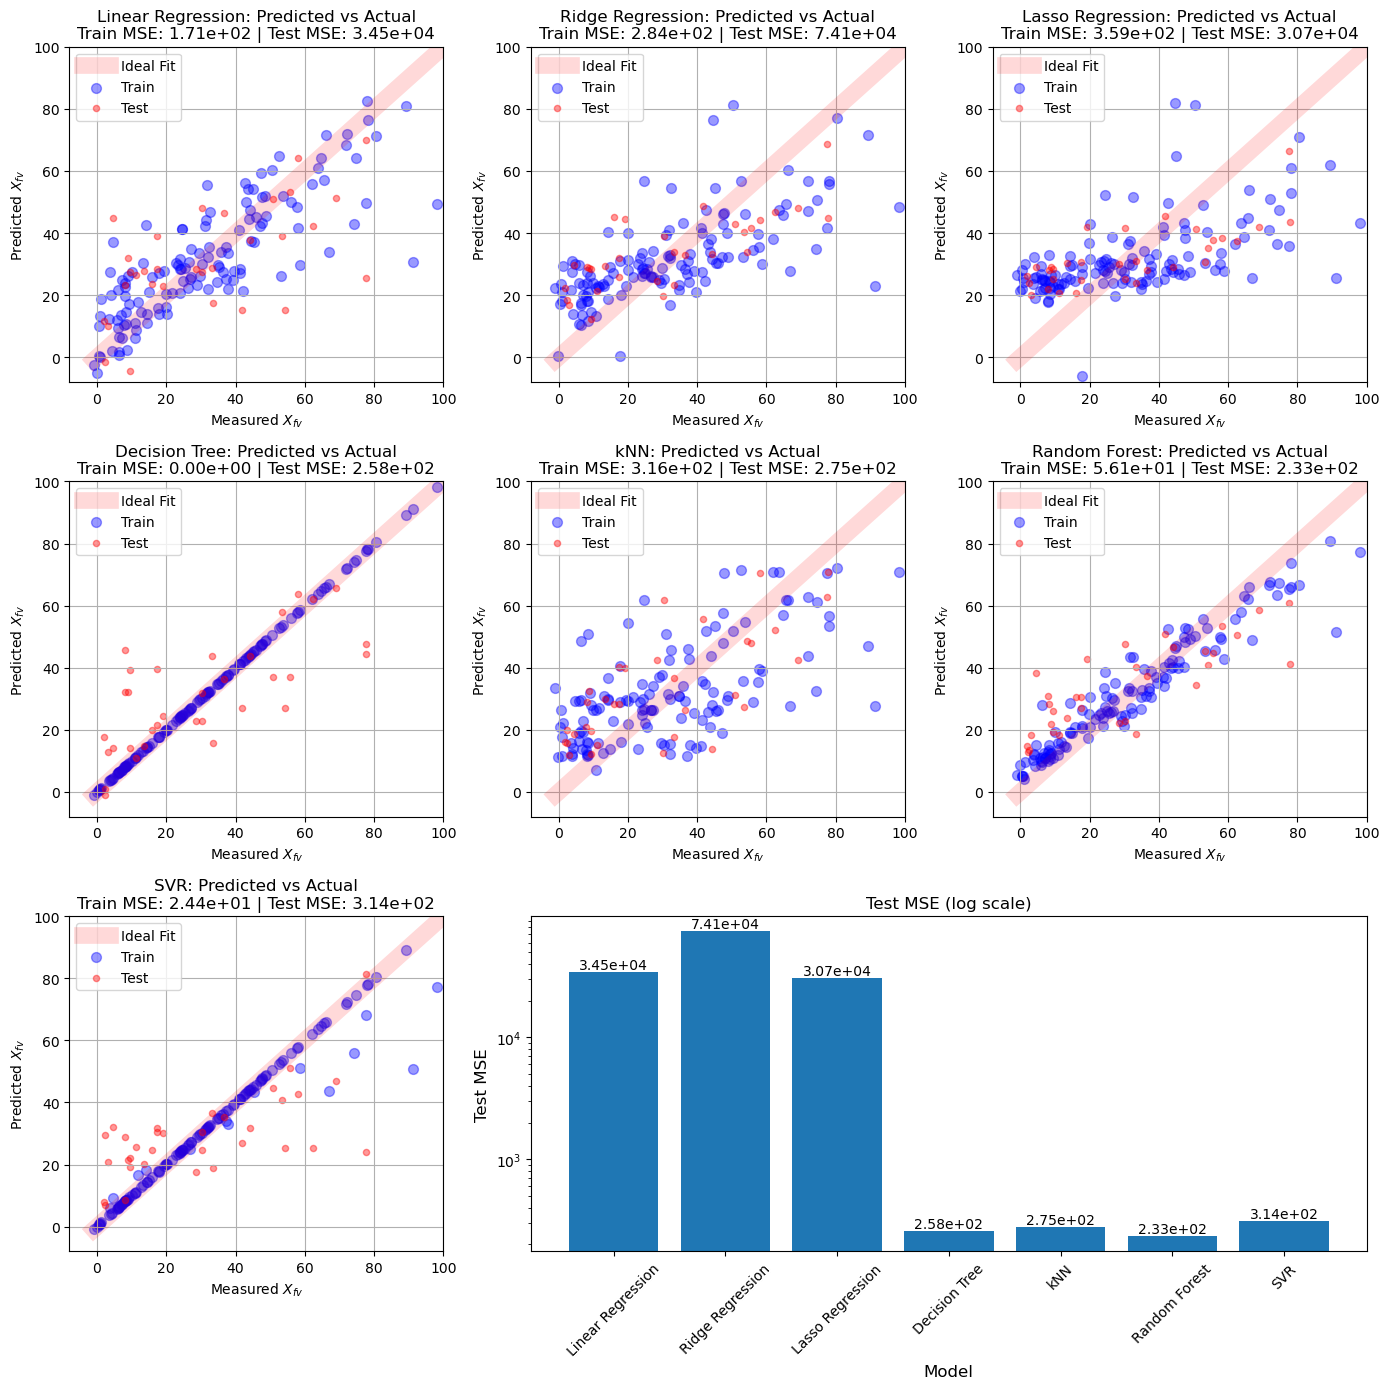

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Assume models, X_train, X_test, Y_train, Y_test, param_grid_svr, and param_grid_rf are already defined

# Dictionary to store test MSE values for each model
mse_values = {}

# Create figure with custom layout:
fig = plt.figure(figsize=(14, 14))

# Define model subplot positions in a 3x3 grid.
# We'll reserve cell at (2,1:3) for the bar plot.
model_positions = [(0, 0), (0, 1), (0, 2),
                   (1, 0), (1, 1), (1, 2),
                   (2, 0)]  # up to 7 models

model_axes = []  # list to store axes for model plots
for pos in model_positions:
    ax = plt.subplot2grid((3, 3), pos)
    model_axes.append(ax)

# Define the bar plot axis to span the last row, columns 1 and 2.
bar_ax = plt.subplot2grid((3, 3), (2, 1), colspan=2)

# Iterate over the models and assign each model plot to an axis
for i, (name, model) in enumerate(models.items()):
    # If there are more models than reserved axes, skip extra models.
    if i >= len(model_axes):
        break

    ax = model_axes[i]
    
    # For models that require scaling and tuning, run GridSearchCV.
    if name in ['Random Forest', 'SVR']:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        if name == 'SVR':
            grid_search = GridSearchCV(SVR(kernel='rbf'),
                                       param_grid_svr,
                                       cv=5,
                                       n_jobs=-1)
            grid_search.fit(X_train_scaled, Y_train)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for SVR: {grid_search.best_params_}")
        elif name == 'Random Forest':
            grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                                       param_grid_rf,
                                       cv=5,
                                       n_jobs=-1)
            grid_search.fit(X_train_scaled, Y_train)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for Random Forest: {grid_search.best_params_}")
        
        # Use the tuned model for predictions on scaled data.
        y_train_pred = best_model.predict(X_train_scaled)
        y_test_pred  = best_model.predict(X_test_scaled)
    else:
        # For other models, assume they are already fitted.
        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test)
    
    # Combine actual values for determining plot limits.
    Y_all = np.concatenate([Y_train, Y_test])
    
    # Calculate MSE for train and test predictions.
    train_mse = mean_squared_error(Y_train, y_train_pred)
    test_mse  = mean_squared_error(Y_test, y_test_pred)
    
    # Store test MSE for the bar plot later.
    mse_values[name] = test_mse
    
    # Plot the ideal fit line.
    ax.plot([Y_all.min(), Y_all.max()], [Y_all.min(), Y_all.max()], 
            color='red', alpha=0.15, linewidth=12, label="Ideal Fit")
    
    # Plot training and test predictions.
    ax.scatter(Y_train, y_train_pred, color='blue', alpha=0.4, s=50, label="Train")
    ax.scatter(Y_test, y_test_pred, color='red', alpha=0.4, s=20, label="Test")
    
    # Set limits (customize as needed).
    ax.set_xlim(-8, 100)
    ax.set_ylim(-8, 100)
    
    # Set title with a newline to display MSE values.
    ax.set_title(f"{name}: Predicted vs Actual\nTrain MSE: {train_mse:.2e} | Test MSE: {test_mse:.2e}", fontsize=12)
    
    # Set axis labels.
    ax.set_xlabel(r'Measured $X_{fv}$', fontsize=10)
    ax.set_ylabel(r'Predicted $X_{fv}$', fontsize=10)
    ax.grid(True)
    ax.legend()

# Create the bar plot on the reserved axis.
model_names = list(mse_values.keys())
mse_scores = list(mse_values.values())

bar_ax.bar(model_names, mse_scores)
bar_ax.set_yscale('log')
bar_ax.set_title("Test MSE (log scale)", fontsize=12)
bar_ax.set_xlabel("Model", fontsize=12)
bar_ax.set_ylabel("Test MSE", fontsize=12)
bar_ax.tick_params(axis='x', rotation=45)

# Optionally, add MSE values on top of the bars.
for j, mse in enumerate(mse_scores):
    bar_ax.text(j, mse, f"{mse:.2e}", ha='center', va='bottom')

plt.tight_layout()
# plt.savefig('Figure_S9.jpg', dpi =600, bbox_inches='tight')
plt.show()
